 #### Docs for VS Code & Jupyter notebooks [here](https://code.visualstudio.com/docs/python/jupyter-support)
 # Jump to sections of interest:
 1. Visualizing Raw Datasets
   1. [Kowalcyzk et al.](#kowal)
   2. [CellBench](#cellbench)
 2. Alignment Method Experiments Results
   1. [Iterative Closest Point (ICP)](#icp)
   2. [ICP 2](#icp2)
   3. [ScAlign](#scalign)
 3. [LISI Performance Metric](#lisi)

### Imports & constants

In [1]:
from collections import defaultdict
from pathlib import Path

#get_ipython().run_line_magic('matplotlib', 'inline')
%matplotlib inline
import anndata
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap
from IPython import display
import torch
import torch.nn as nn
import torch.optim as optim

from scalign import ScAlign

import icp
import metrics

N_PC = 100
FILTER_MIN_GENES = 1.8e3
FILTER_MIN_READS = 10
FILTER_MIN_DETECTED = 5
DO_STANDARDIZE = False


 # Load datasets, clean them, view reduced dimensions

In [2]:
datasets = {}

 ### Functions for cleaning the data (filtering)

In [3]:
def remove_doublets(df_counts, df_meta):
    df_counts = df_counts.loc[df_meta['demuxlet_cls'] == 'SNG', :]
    df_meta = df_meta.loc[df_meta['demuxlet_cls'] == 'SNG', :]
    return df_counts, df_meta

''' Remove cells which do not have at least min_genes detected genes
'''
def filter_cells(df_counts, df_meta, min_genes):
    cell_idx = df_counts.astype(bool).sum(axis=1) > min_genes
    df_counts = df_counts.loc[cell_idx, :]
    df_meta = df_meta.loc[cell_idx, :]
    return df_counts, df_meta

''' Remove genes that don't have at least min_reads number of reads
'''
def filter_low_read_genes(df, min_reads):
    df = df.loc[:, df.sum(axis=0) > min_reads]
    return df

''' Remove genes that don't have at least min_cells number of detections
'''
def filter_low_detected_genes(df, min_cells):
    df = df.loc[:, df.astype(bool).sum(axis=0) > min_cells]
    return df


def clean_counts(df_counts, df_meta, min_lib_size=FILTER_MIN_GENES, min_reads=FILTER_MIN_READS, min_detected=FILTER_MIN_DETECTED):
    # filter out low-gene cells
    df_counts, df_meta = filter_cells(df_counts, df_meta, min_lib_size)
    # remove genes that don't have many reads
    df_counts = filter_low_read_genes(df_counts, min_reads)
    # remove genes that are not seen in a sufficient number of cells
    df_counts = filter_low_detected_genes(df_counts, min_detected)
    return df_counts, df_meta

### Reduce dimensions (PCA, UMAP, t-SNE) & visualize

In [4]:
def embed(datasets, key, do_standardize):
    print('fitting PCA')
    pca_model = PCA(n_components=N_PC).fit(datasets[key].X)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
    ax1.bar(np.arange(N_PC) + 1, pca_model.explained_variance_ratio_)
    ax1.set_ylabel('explained variance')
    ax1.set_xlabel('PC')
    ax2.plot(np.cumsum(pca_model.explained_variance_ratio_))
    ax2.plot(np.ones_like(pca_model.explained_variance_ratio_)*0.9)
    ax2.set_xlabel('number of components')
    ax2.set_ylabel('cumulative explained variance')
    #fig.show()

    if do_standardize:
        # standardize the data for the PCA reduced dimensions (prior to fitting PCA)
        datasets[key].X = StandardScaler().fit_transform(datasets[key].X)
        print('fitting PCA (Standardized)')
        pca_model = PCA(n_components=N_PC).fit(datasets[key].X)
        fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
        ax1.bar(np.arange(N_PC) + 1, pca_model.explained_variance_ratio_)
        ax1.set_ylabel('explained variance')
        ax1.set_xlabel('PC')
        ax2.plot(np.cumsum(pca_model.explained_variance_ratio_))
        ax2.plot(np.ones_like(pca_model.explained_variance_ratio_)*0.9)
        ax2.set_xlabel('number of components')
        ax2.set_ylabel('cumulative explained variance')
    datasets[key].obsm['PCA'] = pca_model.transform(datasets[key].X)
    # # Data standardizer for when using PCA
    # datasets[key].uns['PCA-Standard-Scaler'] = StandardScaler.fit(datasets[key].obsm['PCA'])
    print('fitting UMAP')
    datasets[key].obsm['UMAP'] = umap.UMAP().fit_transform(datasets[key].X)
    print('fitting tSNE')
    datasets[key].obsm['TSNE'] = TSNE(n_components=2).fit_transform(datasets[key].X)

def visualize(datasets, ds_key, cell_type_key='cell_type', batch_key='batch'):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
    fig.suptitle('Embeddings of Original {} Data'.format(ds_key))
    ax1.set_title('PCA')
    ax2.set_title('t-SNE')
    ax3.set_title('UMAP')
    num_batches = len(np.unique(datasets[ds_key].obs[batch_key]))
    opacities = [0.6, 0.2, 0.2][:num_batches]
    markers = ['o', 'o', 'P'][-num_batches:]
    for cell_type, shade in zip(np.unique(datasets[ds_key].obs[cell_type_key]), ['m', 'g', 'c']):
        for batch, opacity, marker in zip(np.unique(datasets[ds_key].obs[batch_key]), opacities, markers):
            idx = np.where((datasets[ds_key].obs[cell_type_key] == cell_type) & (datasets[ds_key].obs[batch_key] == batch))[0]
            for embedding_key, ax in zip(['PCA', 'UMAP', 'TSNE'], [ax1, ax2, ax3]):
                X_subset = datasets[ds_key].obsm[embedding_key][idx, :2]
                ax.scatter(X_subset[:,0], X_subset[:,1], s=20, c=shade, edgecolors='none', marker=marker, alpha=opacity, label='{}_{}'.format(cell_type, batch))
    plt.legend(markerscale=3., loc="upper left", bbox_to_anchor=(1,1))
    plt.subplots_adjust(right=0.85)
    plt.savefig('{}_embeddings.pdf'.format(ds_key), bbox='tight')
    plt.show


 ## Dataset: Kowalcyzk et al.

In [5]:
# Load and clean
counts = pd.read_csv('data/Kowalcyzk/Kowalcyzk_counts.csv', index_col=0).T
meta = pd.read_csv('data/Kowalcyzk/Kowalcyzk_meta.csv', index_col=0)
counts, meta = clean_counts(counts, meta)
adata = anndata.AnnData(X=counts.values, obs=meta)
print(adata.X.shape)
print(adata.obs.info())
datasets['Kowalcyzk'] = adata

(1022, 8354)
<class 'pandas.core.frame.DataFrame'>
Index: 1022 entries, young_LT_HSC_2 to old_MPP_180
Data columns (total 2 columns):
cell_age     1022 non-null object
cell_type    1022 non-null object
dtypes: object(2)
memory usage: 64.0+ KB
None


fitting PCA
fitting UMAP
fitting tSNE


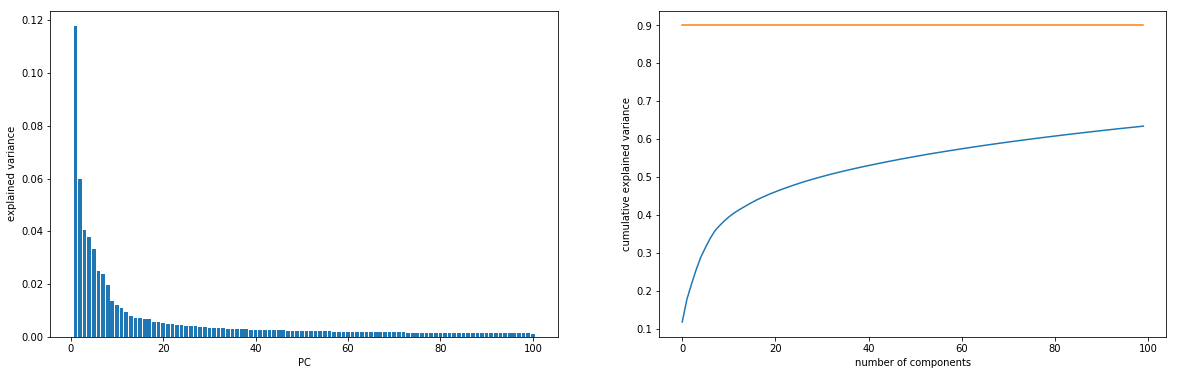

In [6]:
# Reduce dims
embed(datasets, 'Kowalcyzk', do_standardize=DO_STANDARDIZE)

<a name="kowal"></a>
### Kowalcyzk Visualizations

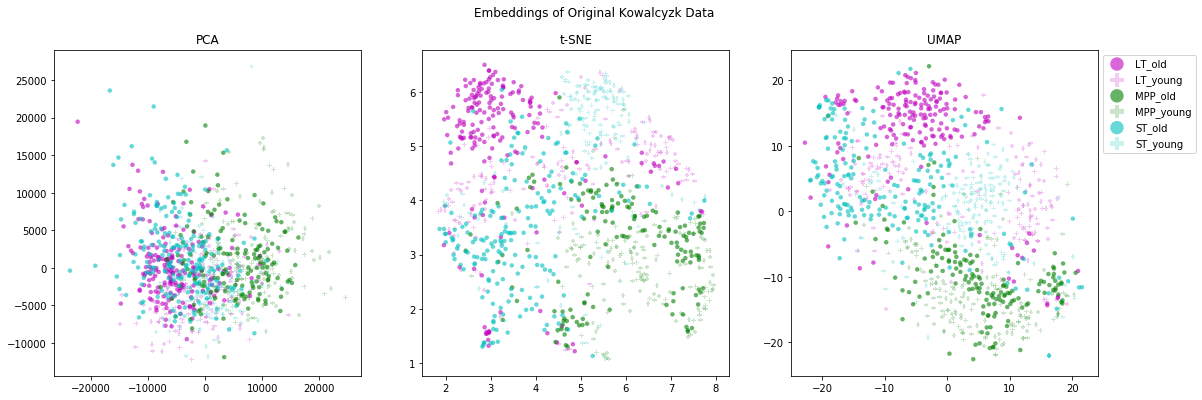

In [7]:
# Visualize
visualize(datasets, 'Kowalcyzk', cell_type_key='cell_type', batch_key='cell_age')

 ## Dataset: CellBench

In [8]:
# Load and clean
protocols = ['10x', 'CELseq2', 'Dropseq']
adatas = []
for protocol in protocols:
    print(protocol)
    counts = pd.read_csv('data/CellBench/{}_counts.csv'.format(protocol), index_col=0).T
    counts = counts.loc[:, ~counts.columns.duplicated()]
    #counts.drop_duplicates(inplace=True)
    meta = pd.read_csv('data/CellBench/{}_meta.csv'.format(protocol), index_col=0)
    counts, meta = remove_doublets(counts, meta)
    counts, meta = clean_counts(counts, meta)
    adatas.append(anndata.AnnData(X=counts.values, obs=meta, var=pd.DataFrame(index=counts.columns)))
    print(adatas[-1].shape)
    #print(adatas[-1].var)
datasets['CellBench'] = anndata.AnnData.concatenate(*adatas, join='inner', batch_key='protocol', batch_categories=protocols)
print('Merged shape: {}'.format(datasets['CellBench'].shape))

10x
(895, 16241)
CELseq2
(240, 16876)
Dropseq
(210, 13987)
Merged shape: (1345, 12829)


fitting PCA
fitting UMAP
fitting tSNE


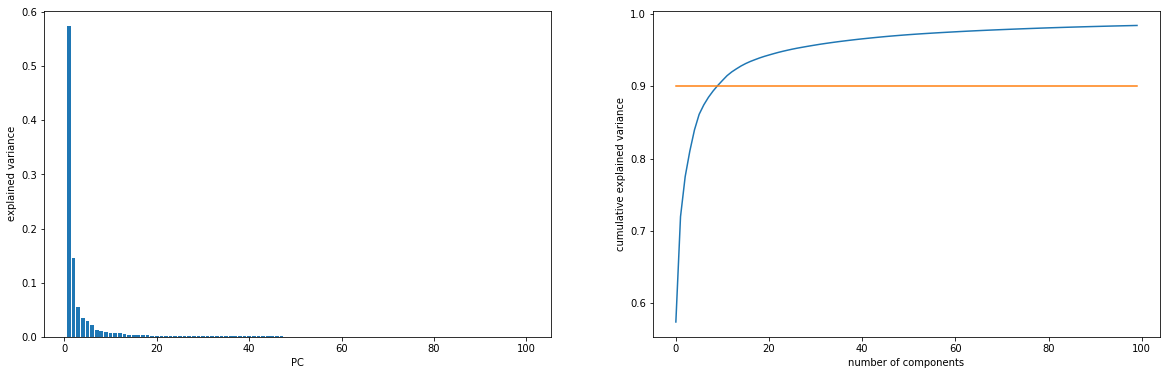

In [9]:
# Reduce dims
embed(datasets, 'CellBench', do_standardize=DO_STANDARDIZE)

<a name="cellbench"></a>
### CellBench Visualizations

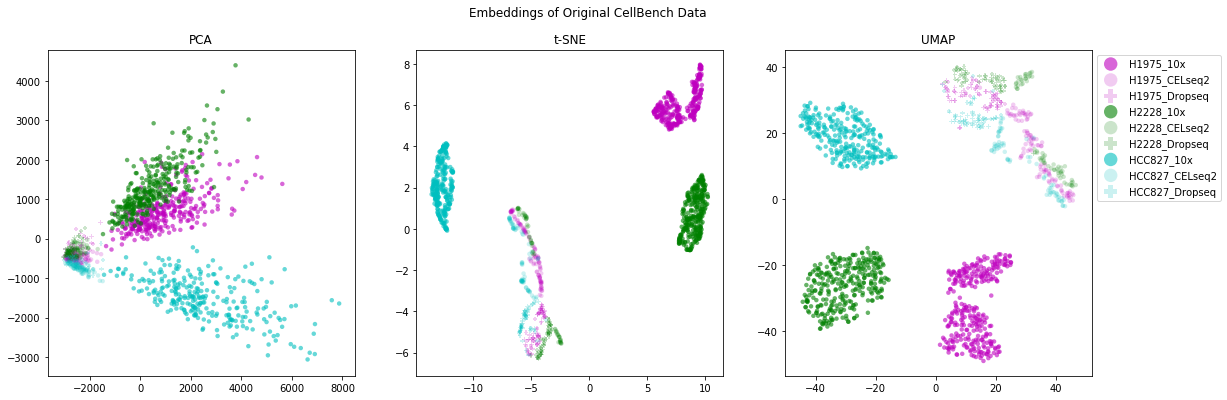

In [10]:
# Visualize
visualize(datasets, 'CellBench', cell_type_key='cell_line_demuxlet', batch_key='protocol')

### Functions to prepare data for input to alignment methods, visualize alignments, score alignments

In [11]:
def get_source_target(datasets, ds_key, batch_key, cell_type_key, source_name, target_name, use_PCA=False):
    source_idx = datasets[ds_key].obs[batch_key] == source_name
    target_idx = datasets[ds_key].obs[batch_key] == target_name
    if use_PCA:
        source = datasets[ds_key].obsm['PCA'][source_idx]
        target = datasets[ds_key].obsm['PCA'][target_idx]
    else:
        source = datasets[ds_key].X[source_idx]
        target = datasets[ds_key].X[target_idx]
    type_index_dict = {}
    combined_types = np.concatenate((datasets[ds_key].obs[cell_type_key][source_idx],
                                     datasets[ds_key].obs[cell_type_key][target_idx]))
    for cell_type in np.unique(combined_types):
        type_index_dict[cell_type] = np.where(combined_types == cell_type)[0]
    subset_meta = pd.concat((datasets[ds_key].obs[source_idx], datasets[ds_key].obs[target_idx]), axis=0)
    return source, target, type_index_dict, subset_meta



def before_and_after_plots(A, B, type_index_dict, aligner_fcn, standardize=True, do_B_transform=False):
    fig, axes = plt.subplots(2, 2, figsize=(20,20))
    # Before alignment
    if standardize:
        scaler = StandardScaler().fit(np.concatenate((A, B)))
        A = scaler.transform(A)
        B = scaler.transform(B)
    A_size = A.shape[0]
    combined = TSNE(n_components=2).fit_transform(np.concatenate((A, B)))
    axes[0,0].scatter(combined[:A_size,0], combined[:A_size,1], c='m', label='source', alpha=0.15)
    axes[0,0].scatter(combined[A_size:,0], combined[A_size:,1], c='b', label='target', alpha=0.15)
    axes[0,0].legend()
    axes[0,0].set_title('t-SNE (before)')
    for cell_type, idx in type_index_dict.items():
        axes[0,1].scatter(combined[idx, 0], combined[idx, 1], label=cell_type, alpha=0.15)
        axes[0,1].legend()
    # Aligned
    A = aligner_fcn(A)
    if do_B_transform:
        B = aligner_fcn(B)
    combined = TSNE(n_components=2).fit_transform(np.concatenate((A, B)))
    axes[1,0].scatter(combined[:A_size,0], combined[:A_size,1], c='m', label='source', alpha=0.15)
    axes[1,0].scatter(combined[A_size:,0], combined[A_size:,1], c='b', label='target', alpha=0.15)
    axes[1,0].legend()
    axes[1,0].set_title('t-SNE (after)')
    for cell_type, idx in type_index_dict.items():
        axes[1,1].scatter(combined[idx, 0], combined[idx, 1], label=cell_type, alpha=0.15)
        axes[1,1].legend()

def compute_lisi(A, B, combined_meta, batch_key, cell_type_key, aligner_fcn, perplexity=30, do_B_transform=False):
    A = aligner_fcn(A)
    if do_B_transform:
        B = aligner_fcn(B)
    X = np.concatenate((A, B))
    print(X.shape)
    assert(X.shape[0] == combined_meta.shape[0])
    return metrics.lisi2(X, combined_meta, [batch_key, cell_type_key], perplexity=perplexity)


## We choose CellBench data, aligning batches: Dropseq --> CELseq2

In [12]:
# Get source and target data
A, B, type_index_dict, combined_meta = get_source_target(datasets, 'CellBench', 'protocol', 'cell_line_demuxlet', 'Dropseq', 'CELseq2', use_PCA=True)

 # 1: Iterative Closest Point

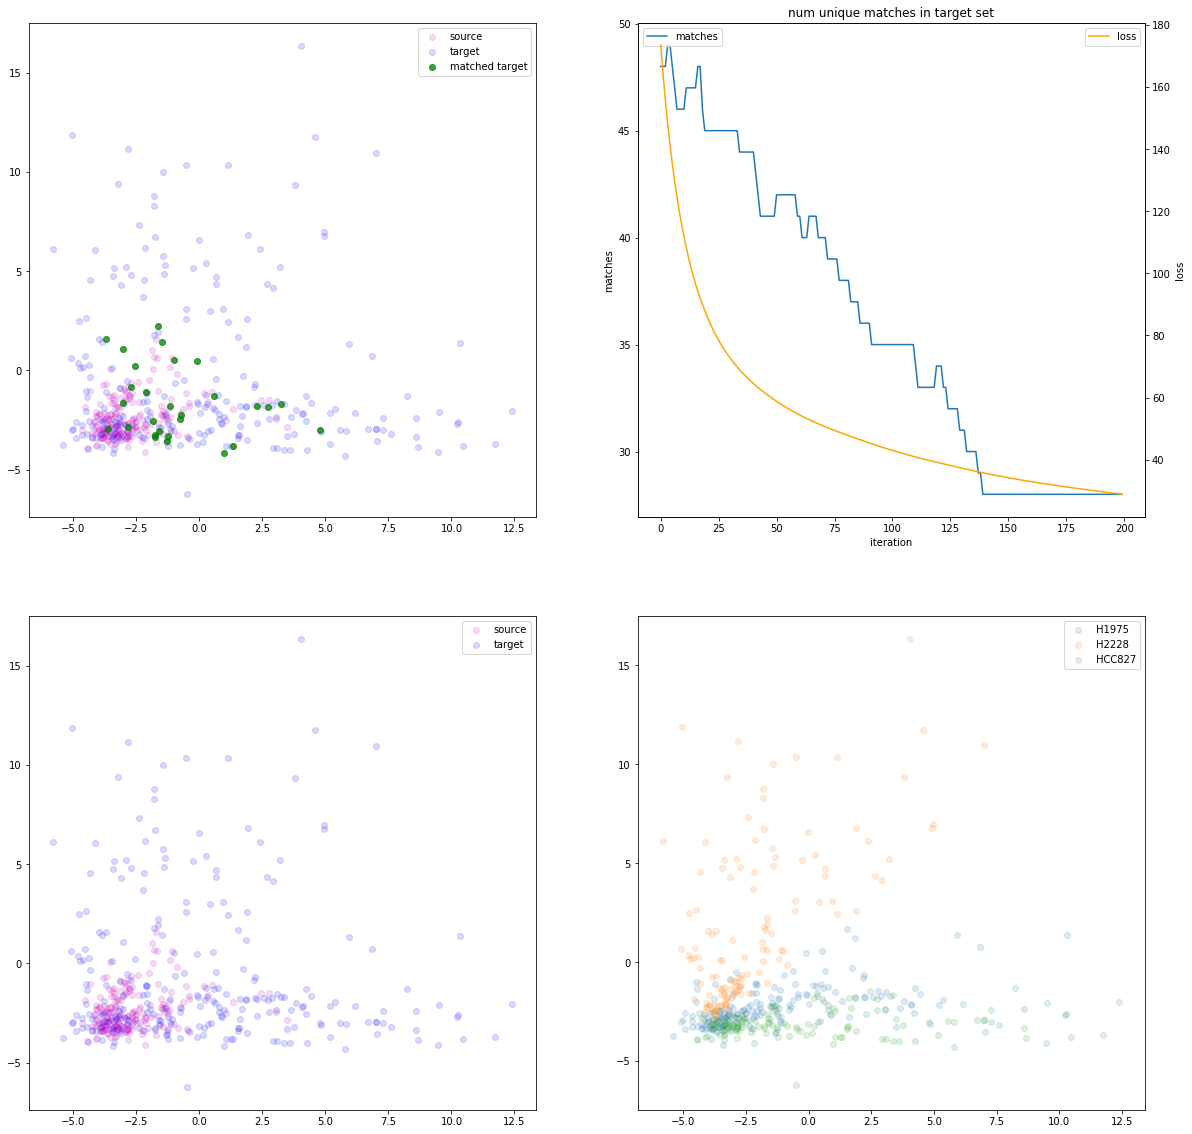

In [13]:
# Align
aligner = icp.ICP(A, B, type_index_dict, loss_function=icp.closest_point_loss, max_iters=200)

<a name="icp"></a>
### ICP, Before vs after alignment

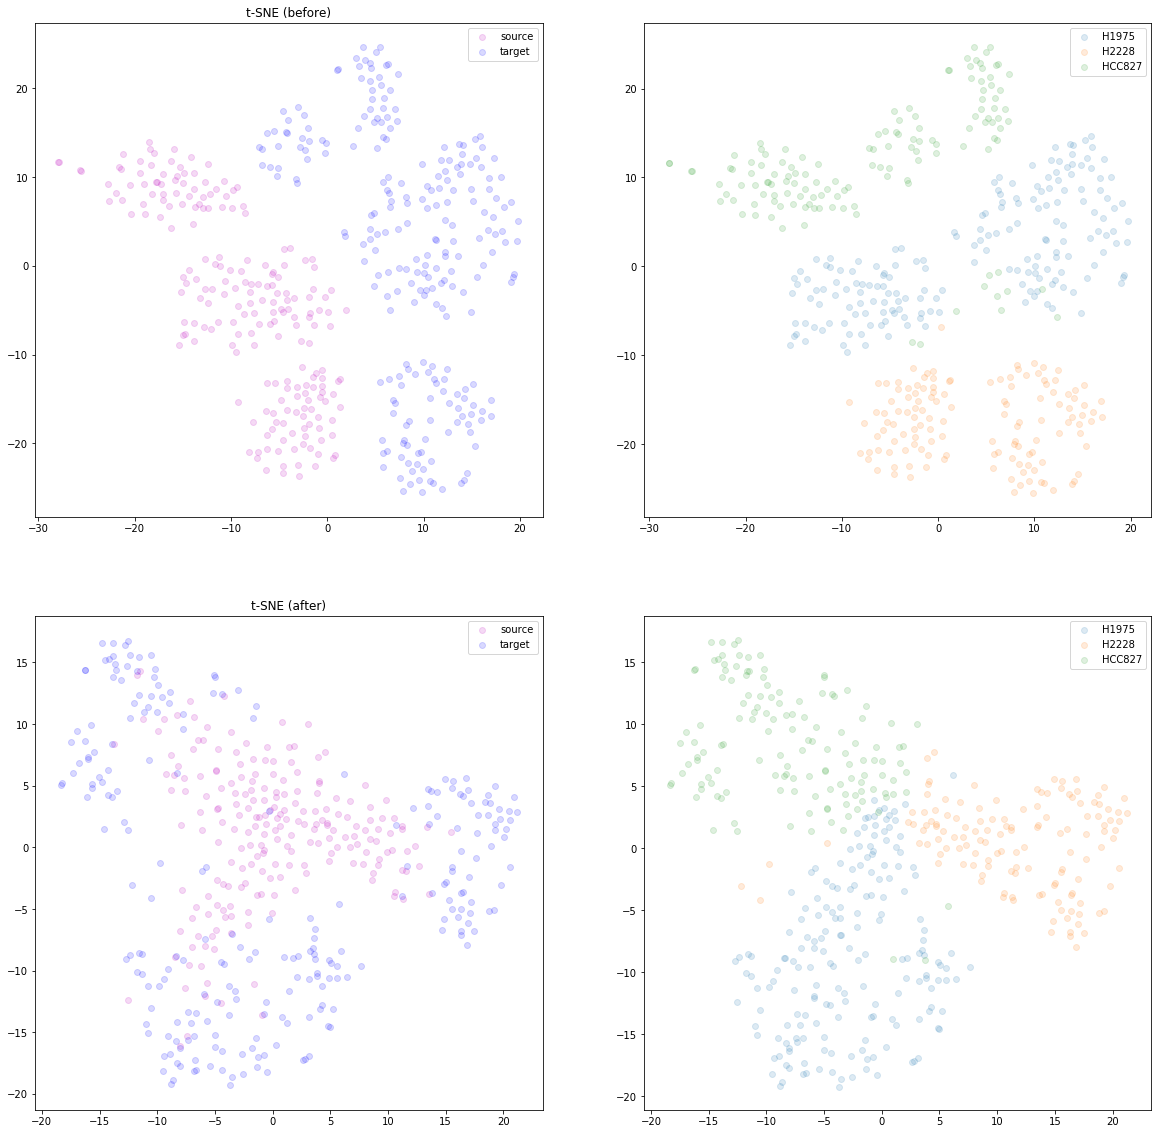

In [14]:
# Get results
aligner_fcn = lambda x: aligner(torch.from_numpy(x).float()).detach().numpy()
before_and_after_plots(A, B, type_index_dict, aligner_fcn=aligner_fcn)

 # 2: Diverse ICP

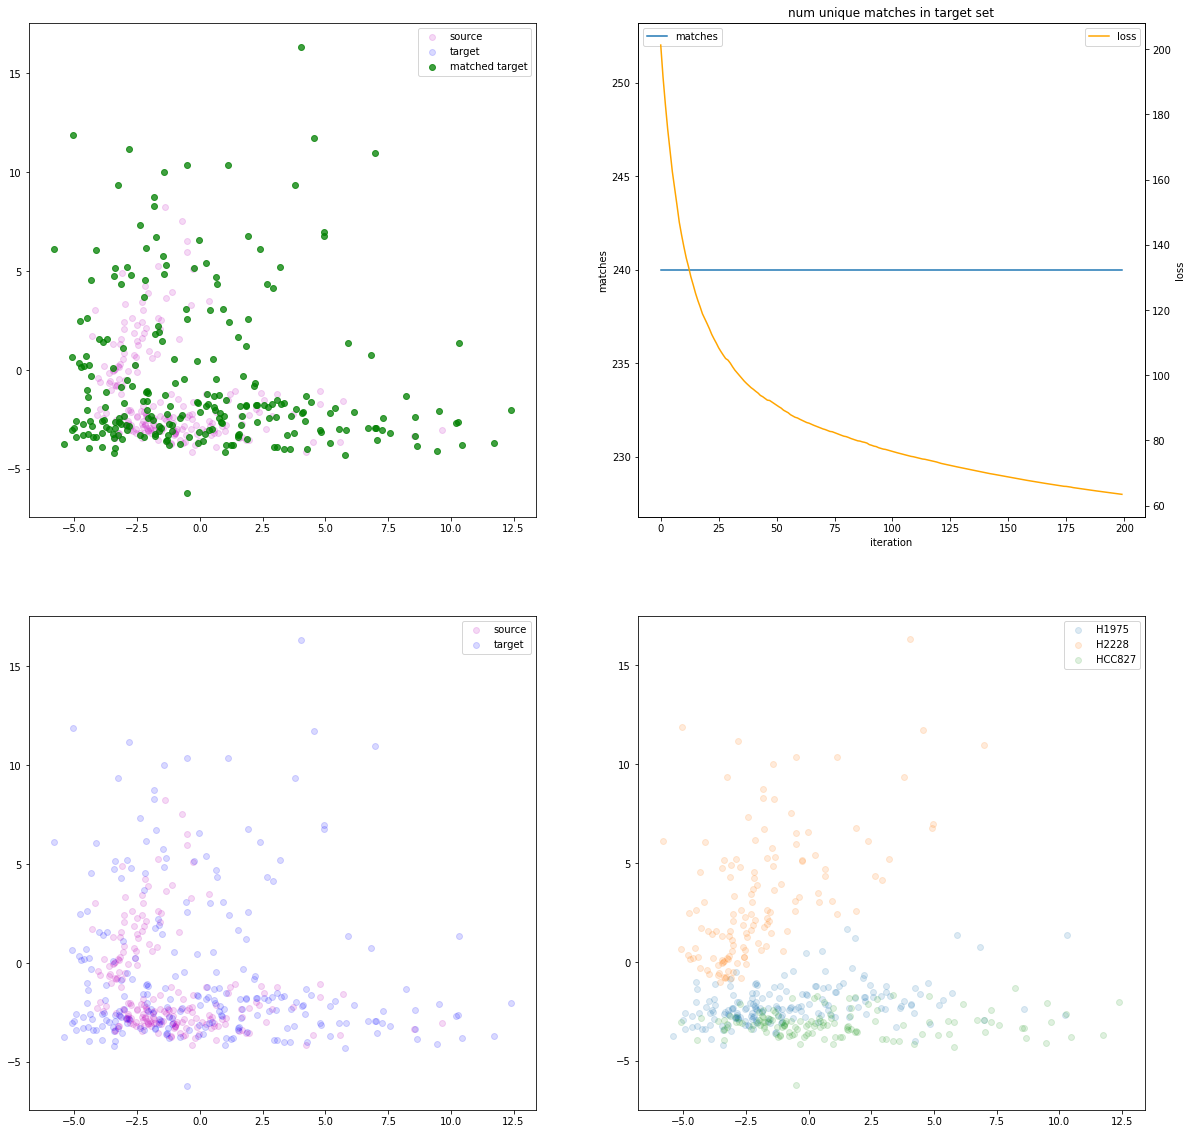

In [15]:
# Align
aligner = icp.ICP(A, B, type_index_dict, loss_function=icp.relaxed_match_loss, max_iters=200)

<a name="icp2"></a>
### ICP2, Before vs after alignment

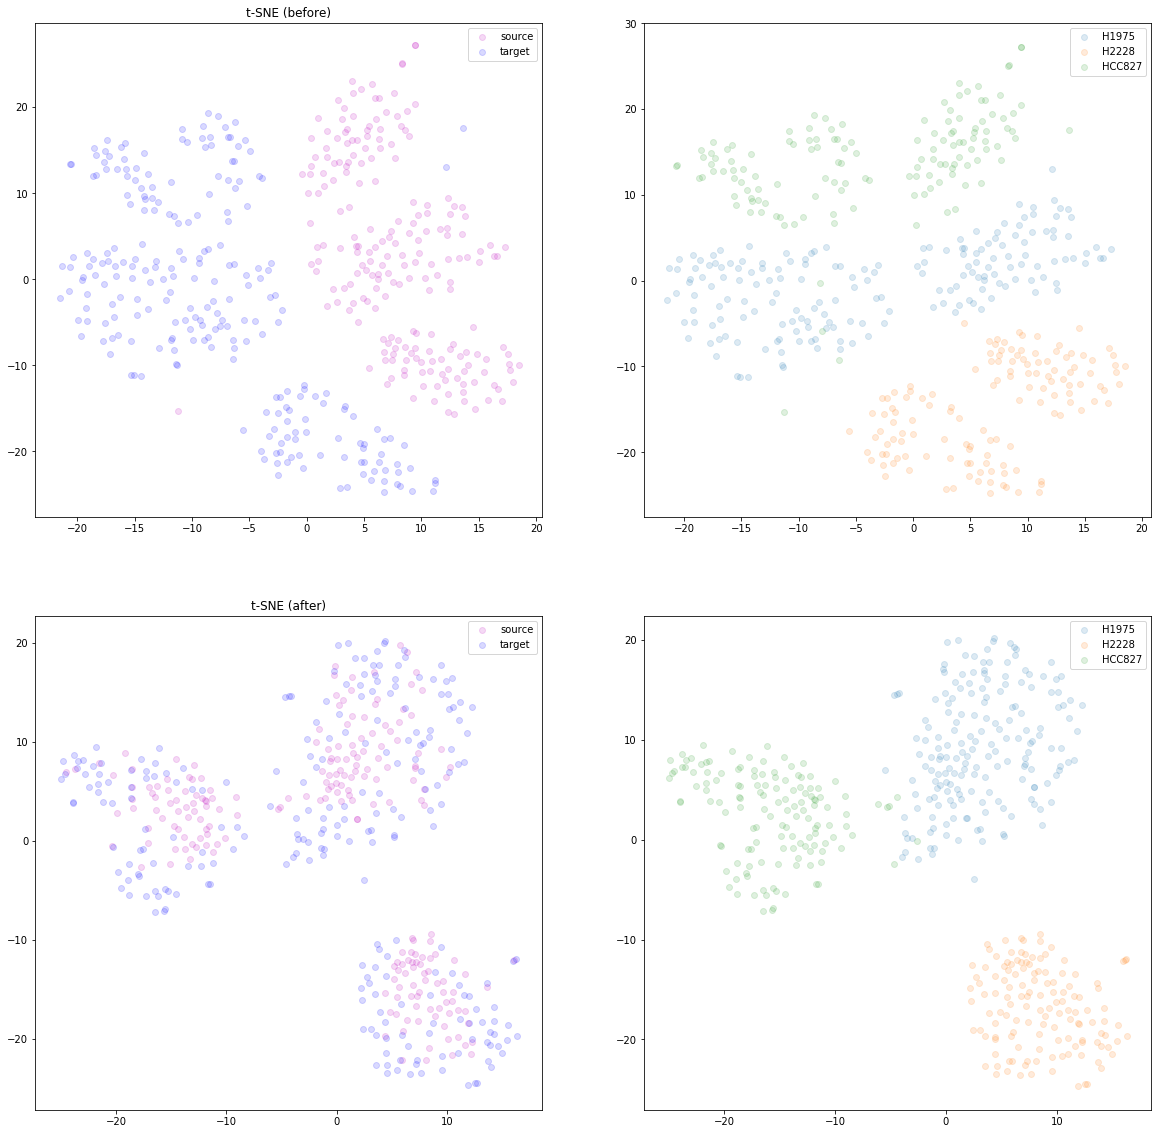

In [16]:
# Get results
aligner_fcn=lambda x: aligner(torch.from_numpy(x).float()).detach().numpy()
before_and_after_plots(A, B, type_index_dict, aligner_fcn=aligner_fcn)

 # 3: ScAlign (Python)

In [17]:
# Align
sc_align = ScAlign(
    object1_name='Dropseq',
    object2_name='CELseq2', 
    object_var='protocol',
    label_var='cell_line_demuxlet',
    data_use='PCA',
    user_options={
        'logdir': 'scAlign_model',
        'log_results': True,
        'early_stop': True
    },
    device='CPU')
sc_align.fit_encoder(datasets['CellBench'])
print('Trained encoder saved to: {}'.format(sc_align.trained_encoder_path_))

============== Encoder training ===============
Graph construction
Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.dropout instead.
NAME OF EMBEDDED TENSOR: data_to_emb_net/net/fc4/BiasAdd:0
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
NAME OF EMBEDDED TENSOR: data_to_emb_net_1/net/fc4/BiasAdd:0
NAME OF EMBEDDED TENSOR: data_to_emb_net_2/net/fc4/BiasAdd:0
Adding source walker loss
Instructions for updating:
Use tf.cast instead.
Adding target walker loss
Instructions for updating:
Use tf.ca

<a name="scalign"></a>
### ScAlign, Before vs after alignment

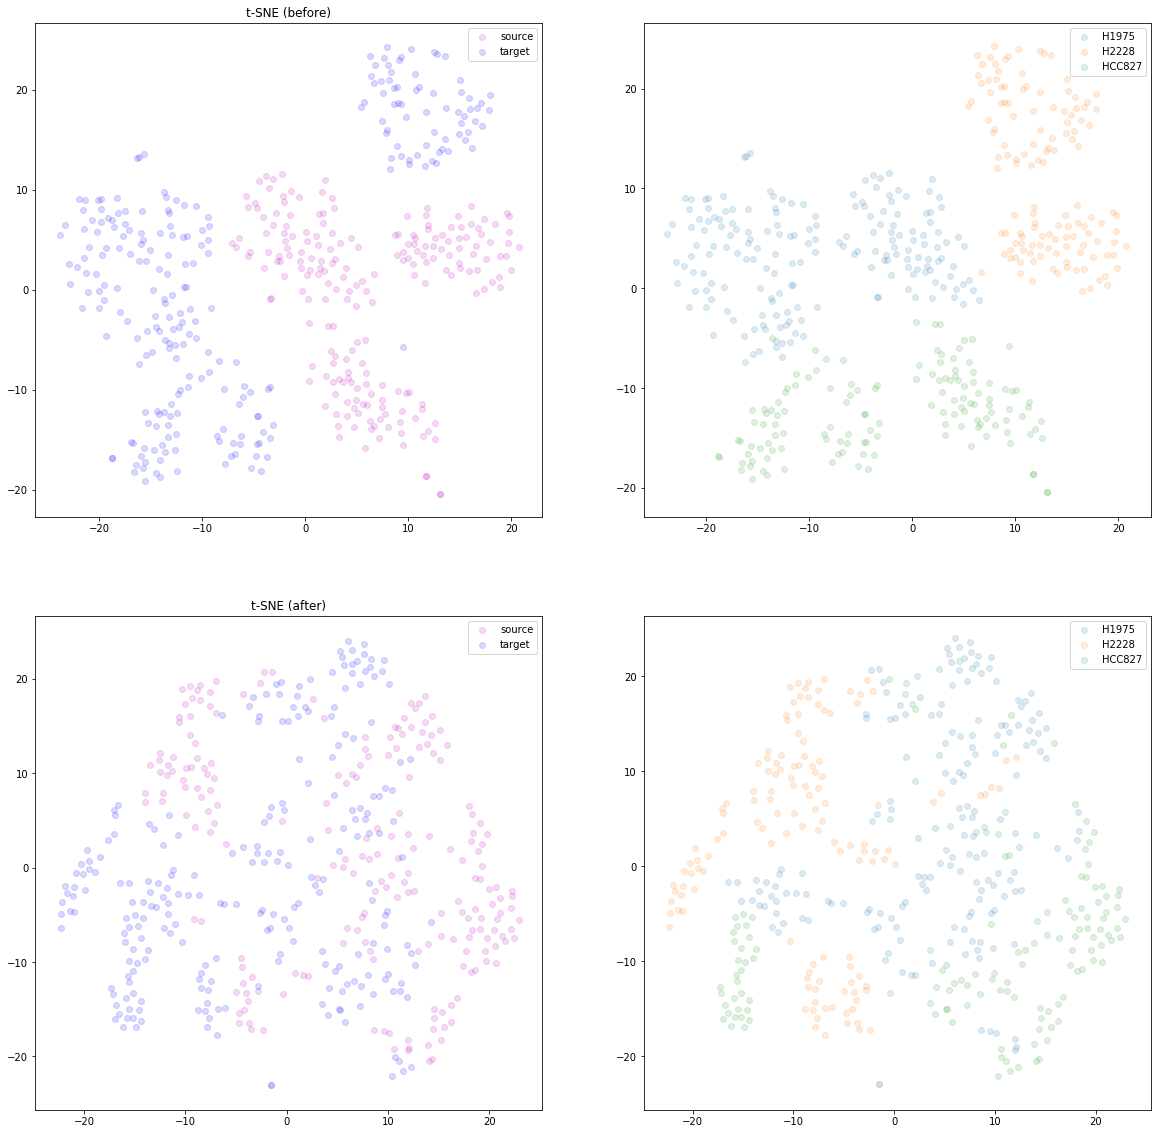

In [18]:
# Get results
#combined_aligned = sc_align.encode(np.concatenate((A, B)))
before_and_after_plots(A, B, type_index_dict, aligner_fcn=sc_align.encode, do_B_transform=True)

 <a name="lisi"></a>
 # LISI score comparisons
 ### From Harmony paper definitions:
 "iLISI measures the degree of mixing among datasets in an embedding, ranging from 1
 in an unmixed space to B in a well mixed space. B is the number of datasets in the
 analysis. cLISI measures integration accuracy using the same formulation but computed
 on cell-type labels instead. An accurate embedding has a cLISI close to 1 for every
 neighborhood"

(450, 100)
(450, 100)
(450, 32)
(450, 100)
(450, 100)
(450, 32)
(450, 100)
(450, 100)
(450, 32)
(450, 100)
(450, 100)
(450, 32)
(450, 100)
(450, 100)
(450, 32)
(450, 100)
(450, 100)
(450, 32)


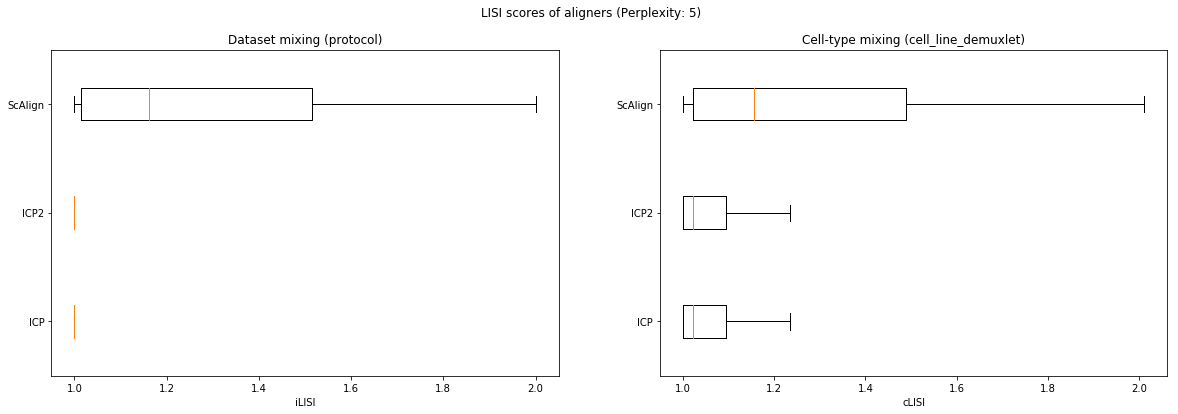

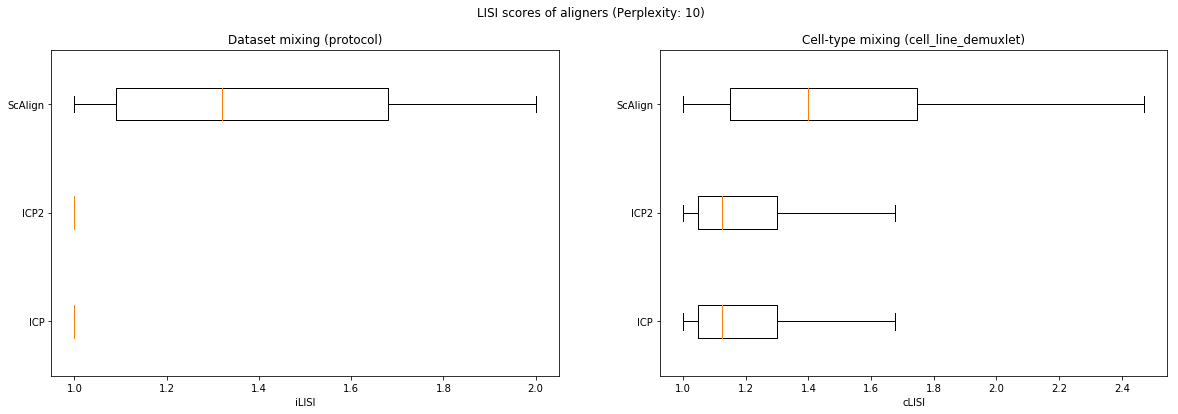

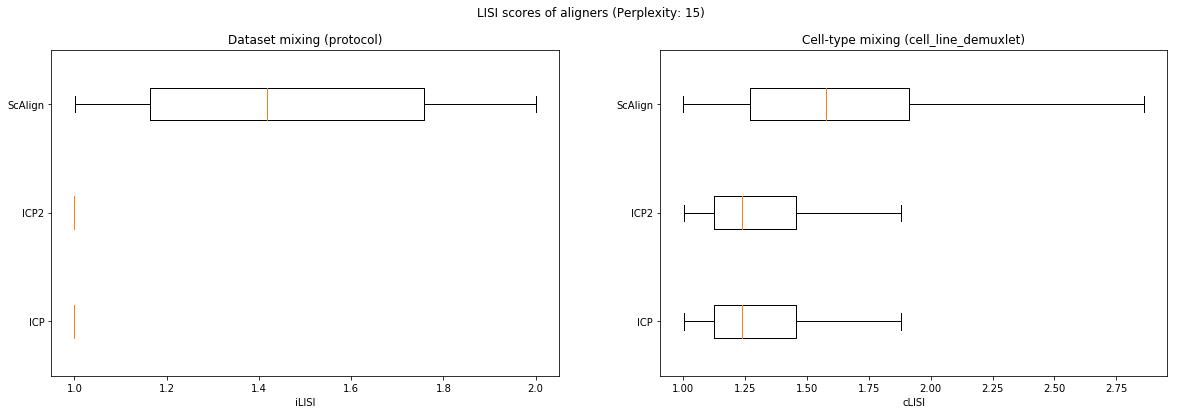

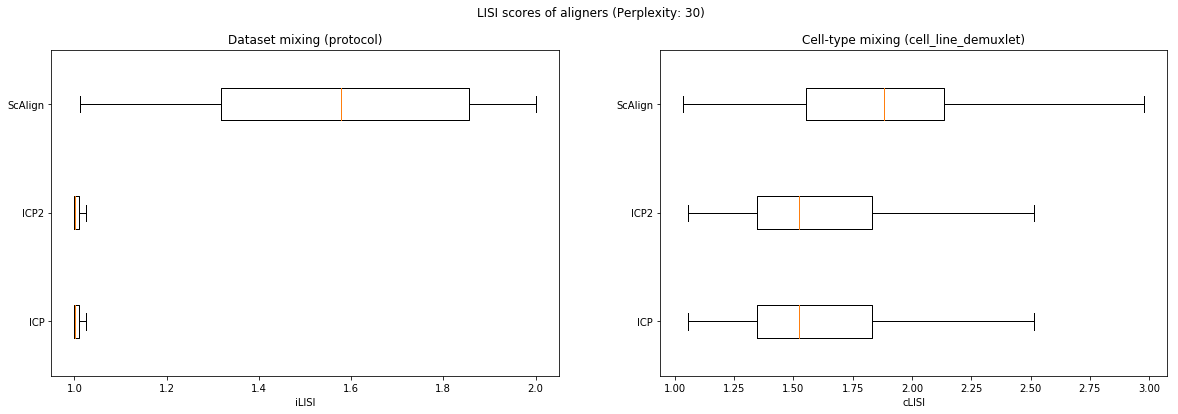

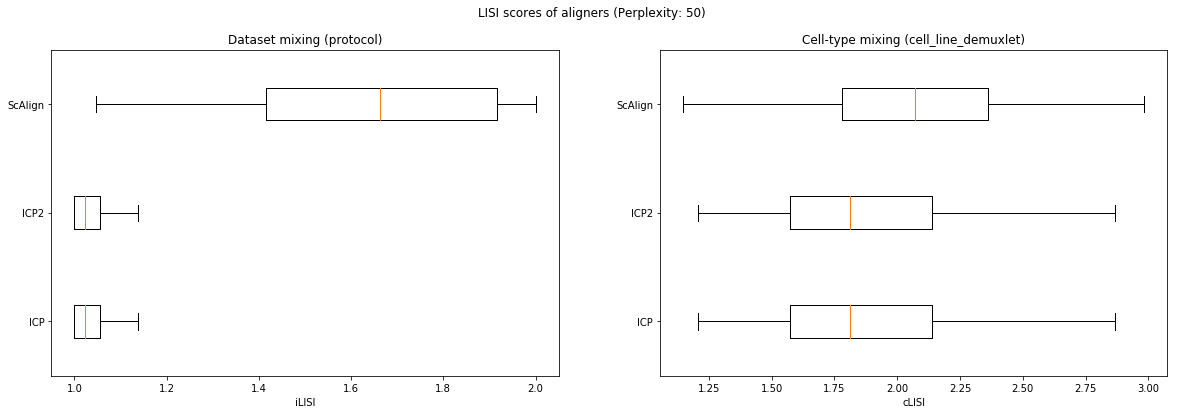

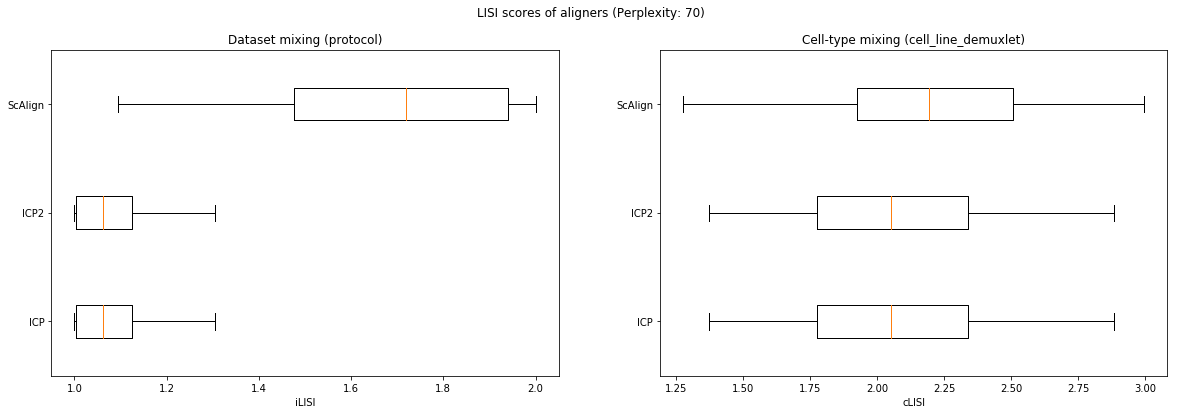

In [21]:
def lisi_score_plot(method_names, lisi_dfs, perplexity, batch_key, cell_type_key):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
    fig.suptitle('LISI scores of aligners (Perplexity: {})'.format(perplexity))
    ax1.set_title('Dataset mixing ({})'.format(batch_key))
    lisi_data = [df[batch_key].values for df in lisi_dfs]
    ax1.boxplot(lisi_data, vert=False, labels=method_names, showfliers=False)
    ax1.set_xlabel('iLISI')
    ax2.set_title('Cell-type mixing ({})'.format(cell_type_key))
    lisi_data = [df[cell_type_key] for df in lisi_dfs]
    ax2.boxplot(lisi_data, vert=False, labels=method_names, showfliers=False)
    ax2.set_xlabel('cLISI')
    #plt.savefig('{}_embeddings.pdf'.format(ds_key), bbox='tight')
    plt.show

    
for plex in [5, 10, 15, 30, 50, 70]:
    icp_lisi = compute_lisi(A, B, combined_meta, batch_key='protocol', cell_type_key='cell_line_demuxlet',
                            aligner_fcn=aligner_fcn, perplexity=plex)
    diverse_icp_lisi = compute_lisi(A, B, combined_meta, batch_key='protocol', cell_type_key='cell_line_demuxlet',
                                    aligner_fcn=aligner_fcn, perplexity=plex)
    scalign_lisi = compute_lisi(A, B, combined_meta, batch_key='protocol', cell_type_key='cell_line_demuxlet',
                                aligner_fcn=sc_align.encode, perplexity=plex, do_B_transform=True)
    
    lisi_score_plot(['ICP', 'ICP2', 'ScAlign'], [icp_lisi, diverse_icp_lisi, scalign_lisi], plex, 'protocol', 'cell_line_demuxlet')


 # 4: (Not implemented) BatchMatch Autoencoder

In [20]:
# from types import SimpleNamespace
# from batch_match.model import DomainInvariantAutoencoder

# args = {
#     'hidden_layer_sizes': ['1000', '100'],
#     'act': 'relu',
#     'dropout': 0,
#     'batch_norm': False
# }
# args = SimpleNamespace(args)
# def get_model(args, input_dim):
#     hidden_layer_sizes = [int(x) for x in args.hidden_layer_sizes]
#     model = DomainInvariantAutoencoder(input_size=input_dim,
#                                        layer_sizes=hidden_layer_sizes,
#                                        act=args.act,
#                                        dropout=args.dropout,
#                                        batch_norm=args.batch_norm)
#     return model


